In [11]:
%%time
import boto3
import re
import sagemaker
from sagemaker import get_execution_role
from sagemaker import image_uris

CPU times: user 13 µs, sys: 0 ns, total: 13 µs
Wall time: 17.6 µs


In [17]:
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

from sagemaker.pytorch import PyTorch

from sagemaker.debugger import (
    Rule, ProfilerRule, rule_configs, 
    DebuggerHookConfig, ProfilerConfig, FrameworkProfile,CollectionConfig
)


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [14]:
import os

In [15]:
!pip install smdebug

# data preperation

In [6]:
# data preperation

# !wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
# !unzip dogImages.zip

In [81]:
root_path = '/home/ec2-user/SageMaker/ImageClassification/dogImages/'

In [82]:
train_path = root_path + 'train/'
valid_path = root_path + 'valid/'
test_path = root_path + 'test/'

# check the dog breeds and consistency

In [83]:
train_dog_breeds = os.listdir(train_path)
valid_dog_breeds = os.listdir(valid_path)
test_dog_breeds = os.listdir(test_path)

In [26]:
if train_dog_breeds == valid_dog_breeds and valid_dog_breeds == test_dog_breeds:
    print('Datasets contain the same dog breeds, so the dog images in the training dataset should be all trained.')

Datasets contain the same dog breeds, so the dog images in the training dataset should be all trained.


In [29]:
print("The number of dog breeds:", len(os.listdir(test_path)))

The number of dog breeds: 133


(320, 314, 3)


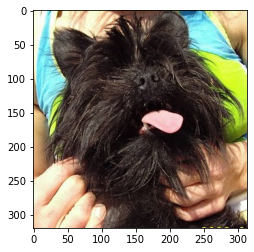

In [98]:
image = plt.imread('/home/ec2-user/SageMaker/ImageClassification/dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg')
plt.imshow(image)

print(image.shape)

(640, 481, 3)


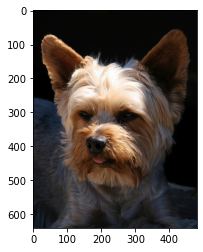

In [99]:
image = plt.imread('/home/ec2-user/SageMaker/ImageClassification/dogImages/test/127.Silky_terrier/Silky_terrier_08055.jpg')
plt.imshow(image)

print(image.shape)

(500, 400, 3)


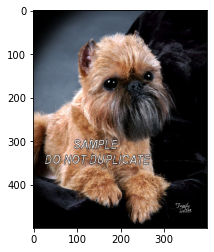

In [104]:
image = plt.imread('/home/ec2-user/SageMaker/ImageClassification/dogImages/test/038.Brussels_griffon/Brussels_griffon_02707.jpg')
plt.imshow(image)

print(image.shape)

In [2]:
import boto3

my_session = boto3.session.Session()
my_region = my_session.region_name

In [3]:
import sagemaker

session = sagemaker.Session()

bucket= session.default_bucket()
print("Default Bucket: {}".format(bucket))

region =  boto3.session.Session().region_name
print("AWS Region: {}".format(region))

role = sagemaker.get_execution_role()
print("RoleArn: {}".format(role))

Default Bucket: sagemaker-ap-southeast-2-263436898058
AWS Region: ap-southeast-2
RoleArn: arn:aws:iam::263436898058:role/service-role/AmazonSageMaker-ExecutionRole-20191212T175637


In [80]:
def extract_image_path(dog_breeds, data_dir, dataset_category):
    image_path_arr = []
    label_arr = []
    for i in dog_breeds:
        for j in os.listdir(data_dir + i):
            image_path_arr.append(f"{dataset_category}/{i}/{j}")
            label_arr.append(int(i.split('.')[0]))
    return image_path_arr, label_arr

train_image_path_arr, train_image_label_arr = extract_image_path(train_dog_breeds, train_path, 'train')
valid_image_path_arr, valid_image_label_arr = extract_image_path(valid_dog_breeds, valid_path, 'valid')
test_image_path_arr, test_image_label_arr = extract_image_path(test_dog_breeds, test_path, 'test')

In [150]:
df_train = pd.DataFrame({
    'filepaths': train_image_path_arr,
    'labels': train_image_label_arr
})

df_valid = pd.DataFrame({
    'filepaths': valid_image_path_arr,
    'labels': valid_image_label_arr
})

df_test = pd.DataFrame({
    'filepaths': test_image_path_arr,
    'labels': test_image_label_arr
})

In [131]:
# df_train = df_train.sample(frac=1).reset_index(drop=True).reset_index()
# df_valid = df_valid.sample(frac=1).reset_index(drop=True).reset_index()
# df_test = df_test.sample(frac=1).reset_index(drop=True).reset_index()

In [157]:
df_train = df_train.reset_index(drop=True).reset_index()
df_valid = df_valid.reset_index(drop=True).reset_index()
df_test = df_test.reset_index(drop=True).reset_index()

In [158]:
df_train.columns = df_train.columns.str.replace('index', 'row')
df_valid.columns = df_valid.columns.str.replace('index', 'row')
df_test.columns = df_test.columns.str.replace('index', 'row')

In [159]:
# make sure that the labels of different dog breeds are from 1-133
list(set(df_test.labels)) == list(range(1, 134))

True

In [41]:
import os

os.environ["DEFAULT_S3_BUCKET"] = bucket
!aws s3 sync ./dogImages/train s3://${DEFAULT_S3_BUCKET}/dog/train/
!aws s3 sync ./dogImages/valid s3://${DEFAULT_S3_BUCKET}/dog/valid/
!aws s3 sync ./dogImages/test s3://${DEFAULT_S3_BUCKET}/dog/test/

In [161]:
def to_metadata_file(df, prefix):
    df["s3_path"] = df["filepaths"]
    df["labels"] = df["labels"]
    
    return df[["row","labels", "s3_path"]].to_csv(
        f"{prefix}.lst", sep="\t", index=False, header=False
    )
    
to_metadata_file(df_train.copy(), "train")
to_metadata_file(df_valid.copy(), "valid")
to_metadata_file(df_test.copy(), "test")

In [8]:
bucket

'sagemaker-ap-southeast-2-263436898058'

In [162]:
boto3.Session().resource('s3').Bucket(
    bucket).Object('dog/train.lst').upload_file('./train.lst')
boto3.Session().resource('s3').Bucket(
    bucket).Object('dog/valid.lst').upload_file('./valid.lst')
boto3.Session().resource('s3').Bucket(
    bucket).Object('dog/test.lst').upload_file('./test.lst')

In [10]:
# sagemaker default image-classification model
# the accuracy can reach around 10%
algo_image = sagemaker.image_uris.retrieve(framework="image-classification", region=region, version="latest")
s3_output_location = f"s3://{bucket}/models/image_model"

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: latest.


In [11]:
img_classifier_model=sagemaker.estimator.Estimator(
    algo_image,
    role,
    instance_count=1,
    instance_type="ml.p2.xlarge",
    output_path=s3_output_location,
    sagemaker_session=session
)

In [177]:
labelled_obj = list(range(1, 134))

img_classifier_model.set_hyperparameters(
    image_shape="3,224,224",
    num_classes=str(len(labelled_obj)),
    num_training_samples=str(len(df_train)),
    learning_rate=0.05,
    mini_batch_size=1,
    augmentation_type='crop_color_transform'
)

In [178]:
from sagemaker.session import TrainingInput

model_inputs = {
        "train": sagemaker.inputs.TrainingInput(
            s3_data=f"s3://{bucket}/dog/",
            content_type="application/x-image"
        ),
        "validation": sagemaker.inputs.TrainingInput(
            s3_data=f"s3://{bucket}/dog/",
            content_type="application/x-image"
        ),
        "train_lst": sagemaker.inputs.TrainingInput(
            s3_data=f"s3://{bucket}/dog/train.lst",
            content_type="application/x-image"
        ),
        "validation_lst": sagemaker.inputs.TrainingInput(
            s3_data=f"s3://{bucket}/dog/valid.lst",
            content_type="application/x-image"
        )
}

# Hyperparameter Tuning

In [8]:
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch_size": CategoricalParameter([32, 64, 128, 256])
}
objective_metric_name = "Test Loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "Test Loss", "Regex": "Testing Loss: ([0-9\\.]+)"}]

In [9]:
estimator = PyTorch(
    entry_point="hpo.py",
    base_job_name="dog_image_classification_resnet18",
    role=role,
    instance_count=1,
    instance_type="ml.p2.xlarge",
    framework_version="1.4.0",
    py_version="py3"
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=1,
    objective_type=objective_type
)

In [16]:
inputs = f"s3://{bucket}/dog/"

In [16]:
s3_data = "s3://{}/{}/".format(bucket, "dog")
s3_output_dir = "s3://{}/{}/".format(bucket, "output")
s3_model_dir = "s3://{}/{}/".format(bucket, "model")


os.environ['SM_CHANNEL_TRAIN']=s3_data
os.environ['SM_MODEL_DIR']=s3_model_dir
os.environ['SM_OUTPUT_DATA_DIR']=s3_output_dir


tuner.fit({'train' : s3_data},wait=True)

.............................................................................................................................................................................................................................................................................................................................................................................................................................................................................!


In [22]:
best_estimator = tuner.best_estimator() #TODO

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2022-04-29 10:19:21 Starting - Preparing the instances for training
2022-04-29 10:19:21 Downloading - Downloading input data
2022-04-29 10:19:21 Training - Training image download completed. Training in progress.
2022-04-29 10:19:21 Uploading - Uploading generated training model
2022-04-29 10:19:21 Completed - Training job completed


{'_tuning_objective_metric': '"Test Loss"',
 'batch_size': '"32"',
 'lr': '0.0013657852356037492',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"dog_image_classification_resnet18-2022-04-29-09-41-55-947"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"ap-southeast-2"',
 'sagemaker_submit_directory': '"s3://sagemaker-ap-southeast-2-263436898058/dog_image_classification_resnet18-2022-04-29-09-41-55-947/source/sourcedir.tar.gz"'}

In [23]:
best_estimator.hyperparameters()

{'_tuning_objective_metric': '"Test Loss"',
 'batch_size': '"32"',
 'lr': '0.0013657852356037492',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"dog_image_classification_resnet18-2022-04-29-09-41-55-947"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"ap-southeast-2"',
 'sagemaker_submit_directory': '"s3://sagemaker-ap-southeast-2-263436898058/dog_image_classification_resnet18-2022-04-29-09-41-55-947/source/sourcedir.tar.gz"'}

In [27]:
int(best_estimator.hyperparameters()["batch_size"].replace('"', ""))

32

In [28]:
best_hyperparameters = {
    "batch-size": int(best_estimator.hyperparameters()["batch_size"].replace('"', "")),
    "lr": best_estimator.hyperparameters()["lr"]
}

In [ ]:
os.environ['SM_CHANNEL_TRAIN']=inputs
os.environ['SM_MODEL_DIR']=s3_model_dir
os.environ['SM_OUTPUT_DATA_DIR']=s3_output_dir

In [29]:
# TODO: Set up debugging and profiling rules and hooks
from sagemaker.debugger import CollectionConfig
rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]


profiler_config = ProfilerConfig(system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=1))
#how to set up debbugging, collectionconfigs
collection_configs=[CollectionConfig(name="CrossEntropyLoss_output",parameters={
    "include_regex": "CrossEntropyLoss_output", "train.save_interval": "10","eval.save_interval": "1"})]
debugger_config=DebuggerHookConfig(collection_configs=collection_configs)

In [34]:
hyperparameters = {"batch_size": "128", "lr": "0.003104434082045644"} 

estimator = PyTorch(
    role=sagemaker.get_execution_role(),
    instance_count=1,
    instance_type="ml.p2.xlarge",
    entry_point="train_model.py",
    framework_version="1.4.0",
    py_version="py3",
    hyperparameters=hyperparameters,
    profiler_config=profiler_config, 
    debugger_hook_config=debugger_config, 
    rules=rules
)

#estimator = estimator.fit(wait=True)# TODO: Your estimator here
#in your notebook, you should specify the location of your training data:(this is from knowledge)
estimator.fit({'train':s3_data}, wait=True)

2022-04-29 11:15:20 Starting - Starting the training job...
2022-04-29 11:15:45 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
.........
2022-04-29 11:17:19 Downloading - Downloading input data...............
2022-04-29 11:19:40 Training - Downloading the training image........bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-04-29 11:20:58,972 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2022-04-29 11:20:59,003 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-04-29 11:20:59,008 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-04-29 11:20:59,442 sagemaker-containers INFO     Module default_user_module_name does not provide a setup.py. 
Generating setup.py
2022-04-29 1

train loss: 409.0000, acc: 30.0000, best loss: 1000000.0000
valid loss: 181.0000, acc: 63.0000, best loss: 181.0000
Testing Model
Test set: Average loss: 182.0000, Accuracy: 65.0
Saving Model
2022-04-29 11:24:03,158 sagemaker-containers INFO     Reporting training SUCCESS

2022-04-29 11:24:21 Uploading - Uploading generated training model
2022-04-29 11:24:41 Completed - Training job completed
ProfilerReport: NoIssuesFound
Training seconds: 433
Billable seconds: 433


In [35]:
# TODO: Create and fit an estimator
#import os
hyperparameters = best_hyperparameters
estimator = PyTorch(
    role=sagemaker.get_execution_role(),
    instance_count=1,
    instance_type="ml.p2.xlarge",
    entry_point="train_model.py",
    framework_version="1.4.0",
    py_version="py3",
    hyperparameters=hyperparameters,
    profiler_config=profiler_config, 
    debugger_hook_config=debugger_config, 
    rules=rules
)

#estimator = estimator.fit(wait=True)# TODO: Your estimator here
#in your notebook, you should specify the location of your training data:(this is from knowledge)
estimator.fit({'train':s3_data}, wait=True)

2022-04-29 11:25:08 Starting - Starting the training job...
2022-04-29 11:25:38 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
.

KeyboardInterrupt: 

In [36]:
training_job_name = estimator.latest_training_job.name
print(f"Training jobname: {training_job_name}")

Training jobname: pytorch-training-2022-04-29-11-25-07-629


In [37]:
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob

job = TrainingJob(training_job_name, region)
job.wait_for_sys_profiling_data_to_be_available()

[2022-04-29 11:26:20.749 ip-172-16-42-147:22739 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


ProfilerConfig:{'S3OutputPath': 's3://sagemaker-ap-southeast-2-263436898058/', 'ProfilingIntervalInMilliseconds': 500, 'ProfilingParameters': {'DataloaderProfilingConfig': '{"StartStep": 0, "NumSteps": 1, "MetricsRegex": ".*", }', 'DetailedProfilingConfig': '{"StartStep": 0, "NumSteps": 1, }', 'FileOpenFailThreshold': '50', 'HorovodProfilingConfig': '{"StartStep": 0, "NumSteps": 1, }', 'LocalPath': '/opt/ml/output/profiler', 'PythonProfilingConfig': '{"StartStep": 0, "NumSteps": 1, "ProfilerName": "cprofile", "cProfileTimer": "total_time", }', 'RotateFileCloseIntervalInSeconds': '60', 'RotateMaxFileSizeInBytes': '10485760', 'SMDataParallelProfilingConfig': '{"StartStep": 0, "NumSteps": 1, }'}}
s3 path:s3://sagemaker-ap-southeast-2-263436898058/pytorch-training-2022-04-29-11-25-07-629/profiler-output
Profiler data from system not available yet
time: 1651231582.841791 TrainingJobStatus:InProgress TrainingJobSecondaryStatus:Starting
Profiler data from system not available yet
Profiler dat

KeyboardInterrupt: 

In [ ]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

print(trial.tensor_names())
print(len(trial.tensor('CrossEntropyLoss_output').steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor('CrossEntropyLoss_output').steps(mode=ModeKeys.EVAL)))

In [ ]:
tensor_name = "CrossEntropyLoss_output"

def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

In [ ]:
plot_tensor(trial, "CrossEntropyLoss_output")

In [ ]:
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts

system_metrics_reader = job.get_systems_metrics_reader()
system_metrics_reader.refresh_event_file_list()

view_timeline_charts = TimelineCharts(
    system_metrics_reader,
    framework_metrics_reader=None,
    select_dimensions=["CPU", "GPU"],
    select_events=["total"],
)

In [ ]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"The profiler report is in {rule_output_path}")

In [ ]:
!aws s3 ls {rule_output_path} --recursive
!aws s3 cp {rule_output_path} ./ --recursive

In [ ]:
# Display the profiler output
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [ ]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

# Model Deploying

In [ ]:
predictor=estimator.deploy(initial_instance_count=1, instance_type="ml.t2.medium")

In [41]:
# model = estimator.output_path + estimator.latest_training_job.job_name + "/output/model.tar.gz"
# print(f"Model: {model}")

In [44]:
model = 's3://sagemaker-ap-southeast-2-263436898058/pytorch-training-2022-04-27-01-13-58-513/output/model.tar.gz'

In [45]:
training_job_name = 'pytorch-training-2022-04-27-01-13-58-513'

In [47]:
deploy_estimator = sagemaker.estimator.Estimator.attach(training_job_name)


2022-04-27 01:51:23 Starting - Preparing the instances for training
2022-04-27 01:51:23 Downloading - Downloading input data
2022-04-27 01:51:23 Training - Training image download completed. Training in progress.
2022-04-27 01:51:23 Uploading - Uploading generated training model
2022-04-27 01:51:23 Completed - Training job completed


In [52]:
from sagemaker.pytorch import PyTorchModel

pytorch_model = PyTorchModel(
    model_data=model, 
    role=role, 
    entry_point='inference.py',
    py_version="py36",
    framework_version="1.8"
)
predictor = pytorch_model.deploy(initial_instance_count=1, instance_type="ml.t2.medium")

-------------!

In [ ]:
!pip3 install torch torchvision --no-cache-dir

# Evaluation 

In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms

In [ ]:
def process_image(image):
    transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
        ])

    preprocessed_image = transform(image).unsqueeze(0)
    preprocessed_image = preprocessed_image.to("cpu")
    
    return preprocessed_image

In [ ]:
real_class_arr = []
pred_class_arr = []
for i in test_dog_breeds:
    for image in os.listdir(test_path + i):
        p = image
        image = Image.open(test_path+i+'/'+image)
    
        preprocessed_image = process_image(image)
        response = predictor.predict(preprocessed_image)
        image = image.resize((256,256))
        pred = np.argmax(response, 1) + 1
        real_class_arr.append(int(i.split('.')[0]))
        pred_class_arr.append(pred[0])

In [ ]:
accuracy = sum(np.array(np.array(real_class_arr) == np.array(pred_class_arr)))/len(pred_class_arr)
print('Accuracy:', round(accuracy,2))

In [ ]:
image_arr = ["./dogImages/test/018.Beauceron/Beauceron_01284.jpg", 
               "./dogImages/test/005.Alaskan_malamute/Alaskan_malamute_00387.jpg", 
               "./dogImages/test/004.Akita/Akita_00244.jpg", 
               "./dogImages/test/012.Australian_shepherd/Australian_shepherd_00887.jpg"]


columns = len(image_arr)
rows = 1
fig = plt.figure(figsize=(20,20))
for i, image_path in enumerate(image_arr):
    # sub img position
    fig.add_subplot(rows, columns, i+1)
    
    image = Image.open(image_path)
    
    preprocessed_image = process_image(image)
    response = predictor.predict(preprocessed_image)
    image = image.resize((256,256))
    pred = np.argmax(response, 1) + 1
        
    plt.imshow(image, interpolation='nearest')
    plt.title(f" probabilities: {round(np.max(response),2)}\n Real Label: {int(image_path[17:20])}\n Pred Label: {pred}")
#plt.savefig(path.join(figures_dir, "visualization_predicted_images.pdf"), bbox_inches = 'tight')
plt.show()